# Effects of joining pairs of families on silhouette

In the "previous notebook", we examined the silhouette coefficient of the existing family clustering with Neighborhood Correlation (NC) and Synteny Correlation (SC) scores applied as edge weights. Now we want to join families together and analyse the effect of this joining to the silhouette of the new families. More specifically, we want to learn if joining candidate families produces a better silhouette than the original families. If so, we are also interested in comparing this the improvement on candidate families to the effects of joining non-candidate pairs.

Since it is computationally expensive to examine all pairs of families, we will consider random and semi-random pairs of families. The following sets of family pairs will be analyzed:
* Candidate pairs
* Purely random pairs 
* Random pairs from complementary sets of species
* Random pairs with a shared neighbor $F_3$ 

Notice that the last two criteria when combined is the basis for finding candidate pairs. 

In [1]:
# Preamble
import sys, math, random, itertools
import matplotlib, matplotlib.pyplot as plt
import numpy as np

% run -i ../scripts/structures/main.py ../data/gene_families/modified_ALL_GENE_file

In [ ]:
#Hiding the scripts
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

The script below allows us to specify the number of random pairs to examine.

In [2]:
# specify number of random families to produce

n_rand = 5000     #number of random families

print("We produce a sample of",n_rand,"random families.")

We produce a sample of 5000 random families.


Create random pairs from the full list of families. With the current algorithm, there is a small chance that some pairs will be repeated. It remains to be seen if these duplicates wil have a significant impact on our results.

In [3]:
famListFull = list(data.familiesDict.keys())
geneListFull = list(data.genesDict.keys())

In [4]:
# Helper functions
# Gives a list of family members for each family

membersList = {}

for famName in data.familiesDict:
    currentFam = data.familiesDict[famName]
    
    geneObjectList = []
    
    for s in data.speciesDict:
        geneObjectList += currentFam.familyMembersDict[s]
        
    membersList[famName] = [g.gene for g in geneObjectList]

Silhouette computations.

In [10]:
# Load NC and SC score file

scoreFile = open("../data/GenFamClust_files/GenFam.syc",'r').readlines()

In [11]:
# Translate GenFam index to true gene names

translation = open("../data/GenFamClust_files/gene_name_translation.txt", 'r').readlines()

geneName = {}

for l in translation:
    x = l.split()
    indexName = x[0]
    trueName = x[1]
    geneName[indexName] = trueName

In [12]:
# Helper function

# Dictionary that maps gene pairs to NC and SC scores
scoreDict = {}

# Dictionary that maps family pairs to edges between them
# Note that GenFam.syc contains two entries for each pair: (g1,g2) and (g2,g1). These have the same scores.
# Therefore, key (f1,f2) is equal to (f2,f1), and (f1,f1) image needs to be halved.
numEdgesDict = {}

for l in scoreFile:
    x = l.split()
    g1 = geneName[x[0]]
    g2 = geneName[x[1]]
    NC = float(x[2])
    SC = float(x[3])
    
    scoreDict[(g1,g2)] = (NC, SC)
    
    f1 = data.genesDict[g1].family
    f2 = data.genesDict[g2].family
    
    try:
        numEdgesDict[(f1,f2)] += 1
    except KeyError:
        numEdgesDict[(f1,f2)] = 1
    

In [6]:
# Computes silhouette for a gene



def geneCohesion(x,ownFam):    
    familyList = revisedMembersList[ownFam]
    NCsum = 0
    SCsum = 0
    
    if len(familyList) > 1:
        for g in familyList:
            if (x,g) in scoreDict:
                NC, SC = scoreDict[(x,g)]

                NCsum += NC
                SCsum += SC

        NCcohesion = NCsum/(len(familyList)-1)
        SCcohesion = SCsum/(len(familyList)-1)
    else:
        NCcohesion = 0.00
        SCcohesion = 0.00
    
    return NCcohesion, SCcohesion


def geneSeparation(x,otherFam):    
    familyList = revisedMembersList[otherFam]
    NCsum = 0
    SCsum = 0
    
    for g in familyList:
        if (x,g) in scoreDict:
            NC,SC = scoreDict[(x,g)]
            
            NCsum += NC
            SCsum += SC
            
    NCseparation = NCsum/len(familyList)
    SCseparation = SCsum/len(familyList)
    return NCseparation, SCseparation


def geneSilhouette(x,ownFam):
    NCcohesion, SCcohesion = geneCohesion(x,ownFam)
    
    NCseparationList = []
    SCseparationList = []
    
    for otherFam in data.familiesDict:
        if f1 != otherFam and f2 != otherFam:     # compare names to save speed
            NC,SC = geneSeparation(x,otherFam)
            
            NCseparationList.append(NC)
            SCseparationList.append(SC)
            
    NCseparation = max(NCseparationList)
    SCseparation = max(SCseparationList)
    
    try: 
        NCsilhouette = (NCcohesion - NCseparation)/ max(NCcohesion,NCseparation)
    except ZeroDivisionError:
        NCsilhouette = 0
    
    try:
        SCsilhouette = (SCcohesion - SCseparation)/ max(SCcohesion,SCseparation) 
    except ZeroDivisionError:
        SCsilhouette = 0
        
    return NCsilhouette, SCsilhouette


In [7]:
# Compute silhouette of a cluster

def clusterSilhouette(family):
    familyList = revisedMembersList[family]
    NCsil = []
    SCsil = []

    
    for g in familyList:
        NC, SC = geneSilhouette(g,family)
        NCsil.append((g,NC))
        SCsil.append((g,SC))
    
    
    NCsilList = [score[1] for score in NCsil]
    SCsilList = [score[1] for score in SCsil]
    
        
    NCsilMin = min(NCsilList)
    NCsilMax = max(NCsilList)
    NCsilAve = sum(NCsilList)/len(NCsilList)
    
    SCsilMin = min(SCsilList)
    SCsilMax = max(SCsilList)
    SCsilAve = sum(SCsilList)/len(SCsilList)
    
    valuesOutNC = [NCsilMin, NCsilMax, NCsilAve]
    valuesOutSC = [SCsilMin, SCsilMax, SCsilAve]
    
    return valuesOutNC, valuesOutSC

## Purely random pairs

In [ ]:
# make purely random family pairs

randAllList = []

for i in range(n_rand):
    f1,f2 = random.sample(famListFull,2)
    randAllList.append((f1,f2))


In [ ]:
randAllList[:10]

## Families with an edge in between

In [13]:
hasEdgesList = list(set(numEdgesDict.keys()))
len(hasEdgesList)

27835

In [14]:
newList = []

for (x,y) in hasEdgesList:
    if x != y:
        newList.append((x,y))
        
hasEdgesList = newList
len(hasEdgesList)

14474

In [15]:
doneMap = {}
newList = []

for (x,y) in hasEdgesList:
    try:
        doneMap[(x,y)]
    except KeyError:
        doneMap[(x,y)] = None
        doneMap[(y,x)] = None
        
        newList.append((x,y))
        
hasEdgesList = newList        
len(hasEdgesList)


7237

In [ ]:
hasEdgesList[:10]

In [ ]:
n_less = 100

randHasEdgesList = []

for i in range(n_less):
    f1,f2 = random.choice(hasEdgesList)
    randHasEdgesList.append((f1,f2))


In [ ]:
randHasEdgesList[:10]

Next, we look for pairs of families $F_1,F_2$, where $F_1$ appears in $x$ species and $F_2$ is missing from those $x$ species. We do this for $1\leq x\leq9$ since we have 18 species in total. We then take random pairs from the set of such families.

In [ ]:
# find complement families


# create an addressBook which contains combinations of species of size 1<x<9.
# find all size 'x' subsets of species. We want each subset to be in order.
addressBook = [] 
speciesList = list(data.speciesDict.keys())
speciesList.sort()

for x in range(1,10):
    addressBook += list(itertools.combinations(speciesList,x)) 


# dictionaries which maps subset (ordered list, in practice) of species to the 
# families which are present only in the subset, and families that are missing in the subset
onlyInSpecies = {}
missingInSpecies = {}


# initialize dictionary entry for every subset
for subsetSpecies in addressBook:
    onlyInSpecies[subsetSpecies] = []
    missingInSpecies[subsetSpecies] = []
    

# sort families into appropriate dictionary and key
for famName in data.familiesDict:
    currentFamily = data.familiesDict[famName]     # family object
    
    inSubset = []    #gives species in which the family appears in
    notInSubset = []     #gives species in which the family does not appear in


    #find a set of species which the family appears in, and another set which the family does not appear in
    for species in currentFamily.familyMembersDict:   
        if len(currentFamily.familyMembersDict[species]) > 0:
            inSubset.append(species)
        else:
            notInSubset.append(species)

            
    # inorder to use species lists as dictionary keys, we need to sort and convert to tuples
    inSubset.sort()
    inTuple = tuple(s for s in inSubset)
    notInSubset.sort()
    notInTuple = tuple(s for s in notInSubset)
    
    
    #add 
    inLen = len(inTuple)
    notinLen = len(notInTuple)
    
    if inLen <= 9 and inLen >0:
        onlyInSpecies[inTuple].append(famName)
    elif notinLen <= 9 and notinLen >0:
        missingInSpecies[notInTuple].append(famName)


In [ ]:
# find list of families part 2

complementList = []

for subsetSpecies in addressBook:
    famListOnly = onlyInSpecies[subsetSpecies]
    famListMissing = missingInSpecies[subsetSpecies]
    
    # if complement families exist (two lists are nonempty), add the cross product to complementList
    if famListOnly and famListMissing:
        complements = list(itertools.product(famListOnly,famListMissing))
        complementList += complements
         

In [ ]:
# make random complement family pairs

randComplementList = []

for i in range(n_rand):
    f1,f2 = random.choice(complementList)
    randComplementList.append((f1,f2))


In [ ]:
randComplementList[:10]

Now we look for pairs $F_1,F_2$ with a shared neighbor $F_3$ (i.e. on one genome, a gene of $F_1$ is adjacent to a gene of $F_3$, and on a different genome, a gene of $F_2$ is adjacent to a gene of $F_3$).

In [ ]:
#make a dictionary which will give information about gene order

Genomes = {}
for s in data.speciesDict:
    Genomes[s] = {}

for g in data.genesDict:
    currentGene = data.genesDict[g]
    try:
        Genomes[currentGene.species][currentGene.ctg].append(currentGene)   #pass gene object
    except KeyError:
        Genomes[currentGene.species][currentGene.ctg] = [currentGene]

        
#sort genes in their contig
for s in Genomes:
    for c in Genomes[s]:
        Genomes[s][c].sort(key = lambda gene: int(gene.start))

In [ ]:
# find all families with a shared neighbor
# with duplicates

nbrFamilies = {}

for s in Genomes:
    for c in Genomes[s]:
        contig = Genomes[s][c]
        ctgSize = len(contig)
        
        if ctgSize > 1:            
            for i in range(ctgSize-1):
                g1 = contig[i]
                g2 = contig[i+1]
                
                f1 = g1.family
                f2 = g2.family
                
                try:
                    nbrFamilies[f1].append(f2)
                except KeyError:
                    nbrFamilies[f1] = [f2]
                    
                try:
                    nbrFamilies[f2].append(f1)
                except KeyError:
                    nbrFamilies[f2] = [f1] 
    

In [ ]:
# find pairs f1,f2 with shared neighbors

hasSharedNbrs= []

# Dictionary used to avoid storing both (f1,f2) and (f2,f1) 
# maps pair in both order to None
done = {}

for f3 in nbrFamilies:
    neighbors = nbrFamilies[f3]
    
    if len(neighbors) > 1:
        pairs = list(itertools.combinations(neighbors,2))
        
        for f1,f2 in pairs:            
            if f1 == f2:
                continue
            else:
                hasSharedNbrs.append((f1,f2))

# delete repeated entries
hasSharedNbrsNoDup = list(set(hasSharedNbrs))

In [ ]:
randSharedNbrNoDupList = []

for i in range(n_rand):
    f1,f2 = random.choice(hasSharedNbrsNoDup)
    randSharedNbrNoDupList.append((f1,f2))


In [ ]:
randSharedNbrNoDupList[:10]

### Candidate pairs

Load candidate family pairs.

In [ ]:
# load synteny files
synteny_k2 = open("../analysis/synteny_in_x_vs_n-x/summary_synteny_in_2_and_n-2-2_species.txt",'r').readlines()
synteny_k3 = open("../analysis/synteny_in_x_vs_n-x/summary_synteny_in_3_and_n-3-2_species.txt",'r').readlines()
synteny_k4 = open("../analysis/synteny_in_x_vs_n-x/summary_synteny_in_4_and_n-4-2_species.txt",'r').readlines()

syntenyList = synteny_k2[1:] + synteny_k3[1:] + synteny_k4[1:]

In [ ]:
#make candidate list

candidateList = []

for l in syntenyList:
    x = l.split()
    f1 = x[0]
    f2 = x[1]
    candidateList.append((f1,f2))
    
#get rid of repeated pairs (instances of (f1,f2) using different f3)
candidateList = list(set(candidateList))



We compare the results for this candidate list to that of a more relaxed candidate list. Relaxed conditions requires $F_1$ (or $F_2$) to be within delta = 5 genes from $F_3$.

In [ ]:
def extendCandidates(delta):
    extsynteny_k2 = open("../results/extended_synteny/delta_"+str(delta)+"/summary/summary_synteny_in_2_and_n-2-2_species.txt",'r').readlines()
    extsynteny_k3 = open("../results/extended_synteny/delta_"+str(delta)+"/summary/summary_synteny_in_3_and_n-3-2_species.txt",'r').readlines()
    extsynteny_k4 = open("../results/extended_synteny/delta_"+str(delta)+"/summary/summary_synteny_in_4_and_n-4-2_species.txt",'r').readlines()

    extsyntenyList = extsynteny_k2[1:] + extsynteny_k3[1:] + extsynteny_k4[1:]
    
    return extsyntenyList

In [ ]:
#make extended candidate lists 

extendedCandidateList = {}


for delta in [2,3,4]:
    extendedCandidateList[delta] = []
    
    extsyntenyList = extendCandidates(delta)

    for l in extsyntenyList:
        x = l.split()
        f1 = x[0]
        f2 = x[1]

        extendedCandidateList[delta].append((f1,f2))

    #get rid of repeated pairs (instances of (f1,f2) using different f3)
    extendedCandidateList[delta] = list(set(extendedCandidateList[delta]))
    

## Join families

In [16]:
# function for joining families

def joinFams(famName1, famName2):
    
    if famName1 == famName2:
        print("Error. Attempting to join same family.")
        return
    
    members1 = membersList[famName1]
    members2 = membersList[famName2]
    membersJ = members1 + members2
        
    revisedMembersList = membersList.copy()
    revisedMembersList["joined"] = membersJ
    del revisedMembersList[f1]
    del revisedMembersList[f2]

    return revisedMembersList
    

In [17]:
# load computed NC silhouette scores for all families

ncSilhouetteFile = open("../results/shuffled_nc_silhouette.txt",'r').readlines()


#dictionary that maps family name to ave nc silhouette
famSilhouette = {}

for l in ncSilhouetteFile[1:]:
    x = l.split()
    
    fam = x[0]
    ncSil = float(x[5])   #ave nc silhouette
    
    famSilhouette[fam] = ncSil

In [ ]:
'''Note to self: Rerun nc_silhouette computations with 6+ sig figs. Then change sig figs shown here '''

In [ ]:
#computes silhouette of joined families and prints desired output

'''
allLists = [randAllList, randHasEdgesList, randComplementList, randSharedNbrNoDupList, candidateList] + list(extendedCandidateList.values())
outputFileNames = ["../results/joined_families_silhouette/random.txt",
                   "../results/joined_families_silhouette/has_edge.txt",
                   "../results/joined_families_silhouette/complement.txt",
                   "../results/joined_families_silhouette/shared_nbr_no_dup.txt",
                   "../results/joined_families_silhouette/candidates.txt"] + [
                    "../results/joined_families_silhouette/candidates_delta2.txt",
                    "../results/joined_families_silhouette/candidates_delta3.txt",
                    "../results/joined_families_silhouette/candidates_delta4.txt"]




#for i in range(len(allLists)):
for i in [1,2,3]:
    pairsList = allLists[i]
    outputfile = outputFileNames[i]
    
    ncOut = open(outputfile,'w')
    ncOut.write("F1 \t F2 \t num_edges_between \t s1 \t s2 \t s \t s12 \t s12-s \n")
    
    for pair in pairsList:
        f1 = pair[0]
        f2 = pair[1]

        s1 = famSilhouette[f1]
        s2 = famSilhouette[f2]

        revisedMembersList = joinFams(f1,f2)

        try:
            numEdgesBetween = numEdgesDict[(f1,f2)]
        except KeyError:
            numEdgesBetween = 0


        valuesOutNC, valuesOutSC = clusterSilhouette("joined")

        s12 = valuesOutNC[2]
      
        ####
        sizef1 = len(membersList[f1])
        sizef2 = len(membersList[f2])

        silSumf1 = s1 * sizef1
        silSumf2 = s2 * sizef2

        s= (silSumf1 + silSumf2) / (sizef1 + sizef2)
        d= s12 - s
        ####
        
        values = [s1, s2, s12, s, d]


        ncOut.writelines([f1,'\t',f2,'\t',str(numEdgesBetween),'\t'])

        for v in values:
            short = "%.4f" % v
            ncOut.write(str(short))
            ncOut.write('\t')

        ncOut.write('\n')
        
        
    ncOut.close()  #close output stream to update result file when finished

        

In [15]:
#Execute script for one group of samples 
#Change pairsList and outputfile



pairsList = hasEdgesList
outputfile = "../results/joined_families_silhouette/shuffled_edges_full.txt"


ncOut = open(outputfile,'w')
ncOut.write("F1 \t F2 \t num_edges_between \t s1 \t s2 \t s12 \t s \t d \n")

for pair in pairsList:
    f1 = pair[0]
    f2 = pair[1]

    s1 = famSilhouette[f1]
    s2 = famSilhouette[f2]

    revisedMembersList = joinFams(f1,f2)

    try:
        numEdgesBetween = numEdgesDict[(f1,f2)]
    except KeyError:
        numEdgesBetween = 0


    valuesOutNC, valuesOutSC = clusterSilhouette("joined")


    sizef1 = len(membersList[f1])
    sizef2 = len(membersList[f2])

    silSumf1 = s1 * sizef1
    silSumf2 = s2 * sizef2

    s= (silSumf1 + silSumf2) / (sizef1 + sizef2)

    s12 = valuesOutNC[2]

    d = s12 - s
    
    values = [s1, s2, s12, s, d]

    ncOut.writelines([f1,'\t',f2,'\t',str(numEdgesBetween),'\t'])

    for v in values:
        short = "%.4f" % v
        ncOut.write(str(short))
        ncOut.write('\t')

    ncOut.write('\n')

ncOut.close()


## Alternative formula for calculating silhouette difference

We shall calculate the difference $d = s_{12} - s$ with adjustments for the relative sizes of $s1$ and $s2$. In other words, instead of $s = \dfrac{(s_1 + s_2)}{2}$, where $s_1,s_2$ are average silhouettes in their respective families, we will use $s' = \dfrac{\sum_{x \in F_1} sil(x) + \sum_{y \in F_2} sil(y) )}{|F_1 + F_2|}$.

## Plots of silhouette difference after joining families

Plot the distribution of the value $s_{12} - s$ for every subset of family pairs. This value describes the change in silhoutte after joining two families.

### Purely random pairs

In [16]:
randomIn = open("../results/joined_families_silhouette/random.txt",'r').readlines()

randomDiff = []

for l in randomIn[1:]:
    x = l.split()
    d = float(x[7])
    randomDiff.append(d)

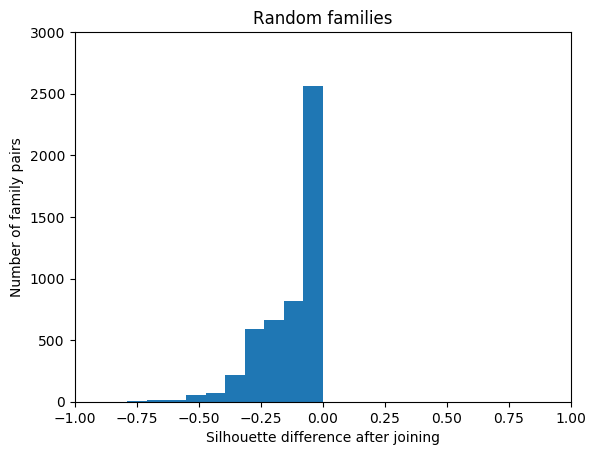

In [17]:
plt.rcdefaults()
fig, ax1 = plt.subplots()

#fig.set_size_inches(10,5)

ax1.set_xlim([-1,1])
ax1.set_ylim([0,3000])

ax1.hist(randomDiff)
ax1.set_xlabel('Silhouette difference after joining')
ax1.set_ylabel('Number of family pairs')
ax1.set_title('Random families')


plt.show()

### Families with an edge between them

In [18]:
hasEdgeIn = open("../results/joined_families_silhouette/has_edge.txt",'r').readlines()

hasEdgeDiff = []

for l in hasEdgeIn[1:]:
    x = l.split()
    d = float(x[7])
    hasEdgeDiff.append(d)

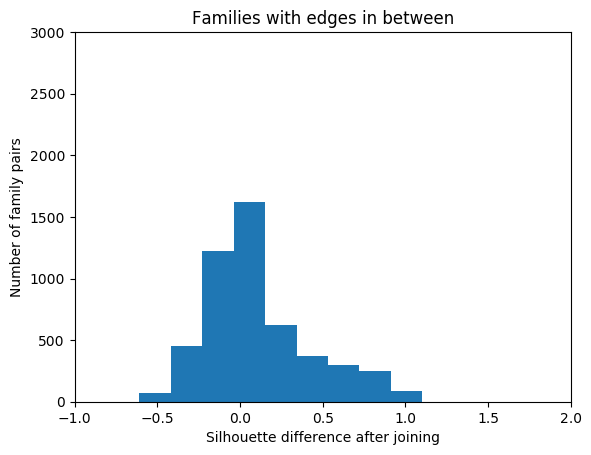

In [19]:
plt.rcdefaults()
fig, ax1 = plt.subplots()

#fig.set_size_inches(10,5)

ax1.set_xlim([-1,2])
ax1.set_ylim([0,3000])

ax1.hist(hasEdgeDiff)
ax1.set_xlabel('Silhouette difference after joining')
ax1.set_ylabel('Number of family pairs')
ax1.set_title('Families with edges in between')


plt.show()

### Complement families

In [20]:
complementIn = open("../results/joined_families_silhouette/complement.txt",'r').readlines()

complementDiff = []

for l in complementIn[1:]:
    x = l.split()
    d = float(x[7])
    complementDiff.append(d)


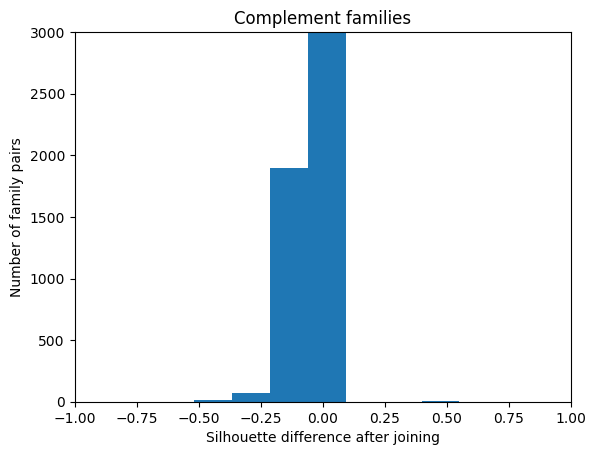

In [21]:
plt.rcdefaults()
fig, ax1 = plt.subplots()

ax1.set_xlim([-1,1])
ax1.set_ylim([0,3000])

ax1.hist(complementDiff)
ax1.set_xlabel('Silhouette difference after joining')
ax1.set_ylabel('Number of family pairs')
ax1.set_title('Complement families')


plt.show()

3 Families with a shared neighbor. No duplicates.

In [22]:
sharedNoDuptIn = open("../results/joined_families_silhouette/shared_nbr_no_dup.txt",'r').readlines()

sharedNoDupDiff = []

for l in sharedNoDuptIn[1:]:
    x = l.split()
    d = float(x[7])
    sharedNoDupDiff.append(d)


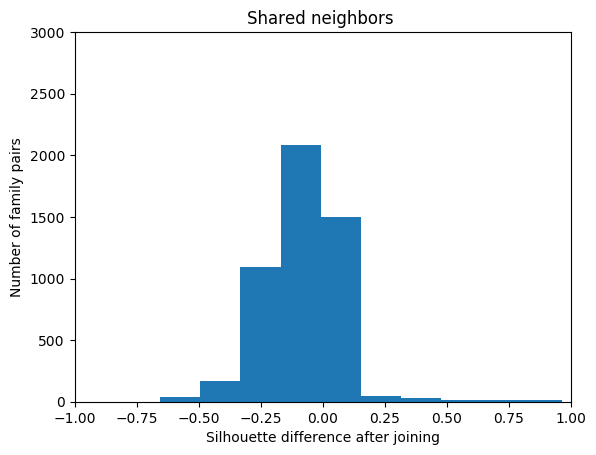

In [23]:
plt.rcdefaults()
fig, ax1 = plt.subplots()


ax1.set_xlim([-1,1])
ax1.set_ylim([0,3000])

ax1.hist(sharedNoDupDiff)
ax1.set_xlabel('Silhouette difference after joining')
ax1.set_ylabel('Number of family pairs')
ax1.set_title('Shared neighbors ')

plt.show()

4 Candidate families

In [24]:
candidateIn = open("../results/joined_families_silhouette/candidates.txt",'r').readlines()

candidateDiff = []
candidateDiffWithEdge = []

for l in candidateIn[1:]:
    x = l.split()
    d = float(x[7])
    candidateDiff.append(d)
    
    f1 = x[0]
    f2 = x[1]
    if (f1,f2) in numEdgesDict or (f2,f1) in numEdgesDict:
        candidateDiffWithEdge.append(d)


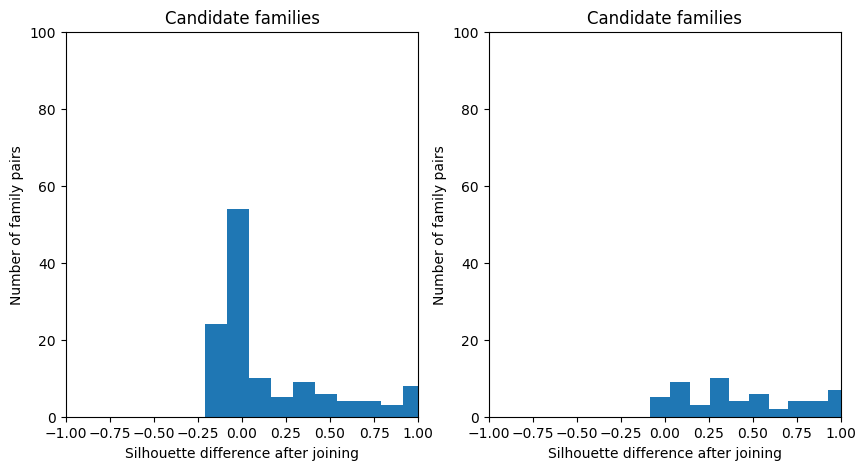

In [25]:
plt.rcdefaults()
fig, (ax1,ax2) = plt.subplots(1,2)

fig.set_size_inches(10,5)


ax1.set_xlim([-1,1])
ax1.set_ylim([0,100])

ax1.hist(candidateDiff)
ax1.set_xlabel('Silhouette difference after joining')
ax1.set_ylabel('Number of family pairs')
ax1.set_title('Candidate families')

ax2.set_xlim([-1,1])
ax2.set_ylim([0,100])

ax2.hist(candidateDiffWithEdge)
ax2.set_xlabel('Silhouette difference after joining')
ax2.set_ylabel('Number of family pairs')
ax2.set_title('Candidate families')


plt.show()

5 Extended candidate families

In [26]:
extendedCandidateDiff = {}
extendedCandidateDiffWithEdge = {}

for delta in [2,3,4]:
    extendedCandidateIn = open("../results/joined_families_silhouette/candidates_delta"+str(delta)+".txt",'r').readlines()

    extendedCandidateDiff[delta] = []
    extendedCandidateDiffWithEdge[delta] = []

    for l in extendedCandidateIn[1:]:
        x = l.split()
        d = float(x[7])
        extendedCandidateDiff[delta].append(d)
        
        f1 = x[0]
        f2 = x[1]
        if (f1,f2) in numEdgesDict or (f2,f1) in numEdgesDict:
            extendedCandidateDiffWithEdge[delta].append(d)


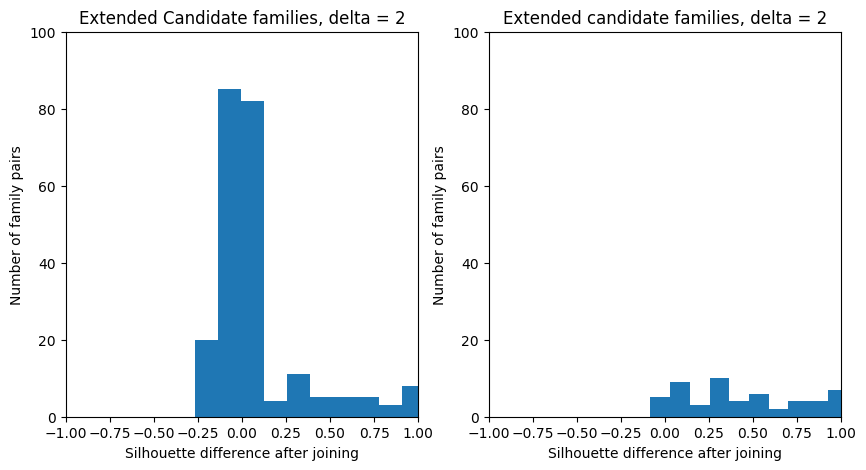

delta = 2 . Contains 228 pairs of families.


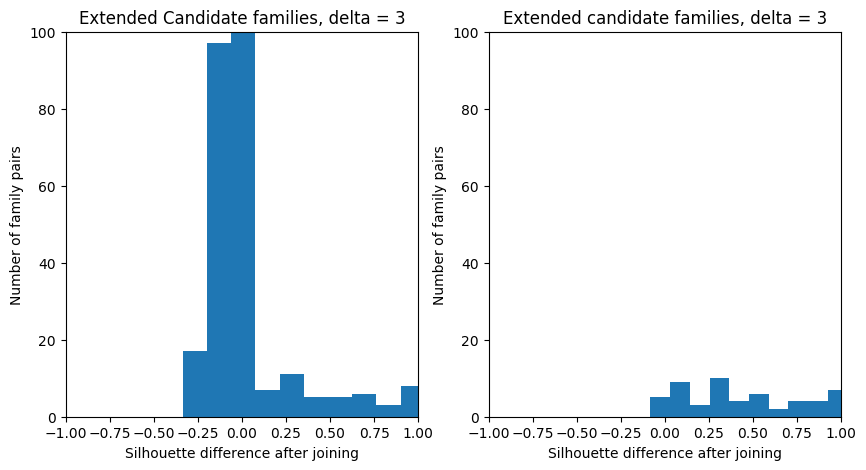

delta = 3 . Contains 409 pairs of families.


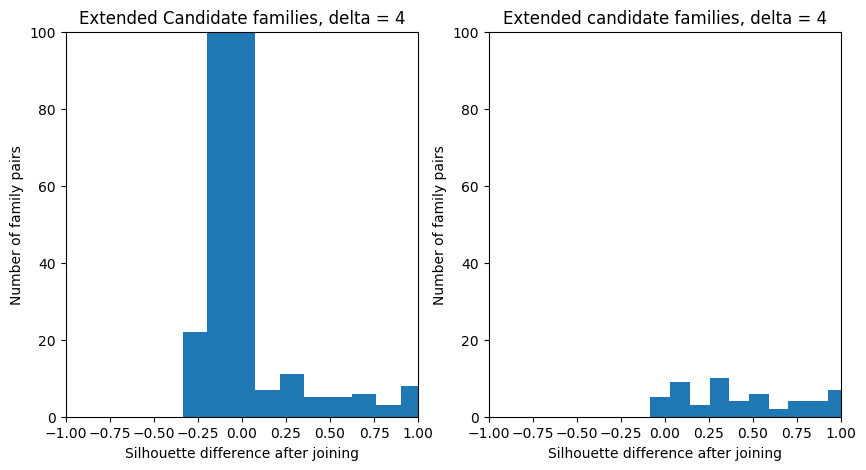

delta = 4 . Contains 605 pairs of families.


In [27]:
for delta in [2,3,4]:
    plt.rcdefaults()
    fig, (ax1,ax2) = plt.subplots(1,2)
    
    fig.set_size_inches(10,5)

    ax1.set_xlim([-1,1])
    ax1.set_ylim([0,100])

    ax1.hist(extendedCandidateDiff[delta])
    ax1.set_xlabel('Silhouette difference after joining')
    ax1.set_ylabel('Number of family pairs')
    ax1.set_title('Extended Candidate families, delta = '+str(delta))
    
    ax2.set_xlim([-1,1])
    ax2.set_ylim([0,100])

    ax2.hist(extendedCandidateDiffWithEdge[delta])
    ax2.set_xlabel('Silhouette difference after joining')
    ax2.set_ylabel('Number of family pairs')
    ax2.set_title('Extended candidate families, delta = '+str(delta))

    plt.show()
    
    print('delta =',delta,'. Contains',len(extendedCandidateDiff[delta]),'pairs of families.')